## In this notebook, we'll use pretrained models with our pizza, steak, sushi data.

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
""" We're well beyond those versions now, no need to download nightly versions
try:
  import torch
  import torchvision
  assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
  assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
except:
  print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
  !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
  import torch
  import torchvision
"""
import torch
import torchvision
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


In [ ]:
# Continue with regular imports
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


In [ ]:
# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
  from going_modular import data_setup, engine
except:
  """
  This block attempts to download a GitHub repository,
  move a specific directory from the downloaded repository to the current working directory,
  and then remove the downloaded repository.
  """
  # Get the going_modular scripts
  print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")

  # Clone the git repository
  !git clone https://github.com/lanehale/pytorch-deep-learning

  # When cloning a GitHub repository, the directory structure on your local machine doesn't include /tree/main/, so it shouldn't be included in the mv command.
  # The . at the end of the command tells mv to move the specified directory into the current working directory.
  !mv pytorch-deep-learning/going_modular .

  # remove the downloaded repository
  !rm -rf pytorch-deep-learning

  from going_modular import data_setup, engine

[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 240, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 240 (delta 36), reused 11 (delta 11), pack-reused 179 (from 1)
Receiving objects: 100% (240/240), 36.37 MiB | 20.33 MiB/s, done.
Resolving deltas: 100% (118/118), done.


In [ ]:
!ls

going_modular  sample_data


In [ ]:
!mv going_modular/train.py .
!mv going_modular/predict.py .
!ls

going_modular  predict.py  sample_data	train.py


In [ ]:
!ls going_modular/

data_setup.py	  get_any_data.py     model_builder.py	     __pycache__
download_data.py  get_custom_data.py  pretrained_confmat.py  utils.py
engine.py	  get_data.py	      pretrained_writer.py


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Train the (EffNetB0) model with more data

In [ ]:
"""
Ex 5. Train the model with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images
      (My get_data.py already uses the larger, 20% dataset)
"""
# Get images
!python going_modular/get_data.py

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [ ]:
from pathlib import Path
image_path = Path("data/pizza_steak_sushi")

# Set up dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [ ]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224,224)),  # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(),         # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # 3. A mean of [...] across each color channel
                         std=[0.229, 0.224, 0.225])   # A standard deviation of [...] across each color channel
])

In [ ]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader_man, test_dataloader_man, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,  # resize, convert images to between 0 & 1 and normalize them
    batch_size=32
)
train_dataloader_man, test_dataloader_man, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7859b7509d90>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
""" As of torchvision v0.13+, an automatic transform creation feature has been added. """
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT  # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
"""
And now to access the transforms associated with our weights, we can use the transforms() method.
This is essentially saying "get the data transforms that were used to train the EfficientNet_B0_Weights on ImageNet".
"""
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [ ]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transforms,  # perform the same data transforms on our training data as the pretrained model
    batch_size=32
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7859b7501ad0>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# OLD: Set up the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

# NEW: Set up the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT  # .DEFAULT = best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

#model # uncomment to output (it's very long) and see dropout rate and number of in_features

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 69.0MB/s]


In [ ]:
# Print a summary using torchinfo
summary(model=model,
        input_size=(32, 3, 224, 224),
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
  param.requires_grad = False

In [ ]:
""" Adjust the output layer or the classifier portion of our pretrained model to our needs (out_features=3). """
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,  # same number of output units as our number of classes
                    bias=True)).to(device)

In [ ]:
# Do a summary *after* freezing the features and changing the output classifier layer
summary(model=model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [ ]:
""" Because we're still working with multi-class classification, we'll use "CrossEntropyLoss" as our loss function. """
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train the model for longer

In [ ]:
"""
Ex 4. Train the model for longer (10 epochs should do)
"""
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

""" Note: We're only going to be training the parameters classifier here as all of the other parameters in our model have been frozen. """
# Set up training and save the results (The train() function is in the engine.py script inside the going_modular directory.)
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9784 | train_acc: 0.5583 | test_loss: 0.6719 | test_acc: 0.8915
Epoch: 2 | train_loss: 0.7148 | train_acc: 0.8167 | test_loss: 0.5588 | test_acc: 0.8727
Epoch: 3 | train_loss: 0.6047 | train_acc: 0.7937 | test_loss: 0.4808 | test_acc: 0.8915
Epoch: 4 | train_loss: 0.4569 | train_acc: 0.9000 | test_loss: 0.4338 | test_acc: 0.8756
Epoch: 5 | train_loss: 0.4566 | train_acc: 0.8812 | test_loss: 0.4090 | test_acc: 0.8858
Epoch: 6 | train_loss: 0.4367 | train_acc: 0.8812 | test_loss: 0.3729 | test_acc: 0.9068
Epoch: 7 | train_loss: 0.4260 | train_acc: 0.8458 | test_loss: 0.3458 | test_acc: 0.9097
Epoch: 8 | train_loss: 0.4209 | train_acc: 0.8479 | test_loss: 0.3594 | test_acc: 0.8642
Epoch: 9 | train_loss: 0.3432 | train_acc: 0.8729 | test_loss: 0.3190 | test_acc: 0.9165
Epoch: 10 | train_loss: 0.3720 | train_acc: 0.8750 | test_loss: 0.3107 | test_acc: 0.8915
[INFO] Total training time: 45.987 seconds


[INFO] Couldn't find helper_functions.py, downloading...


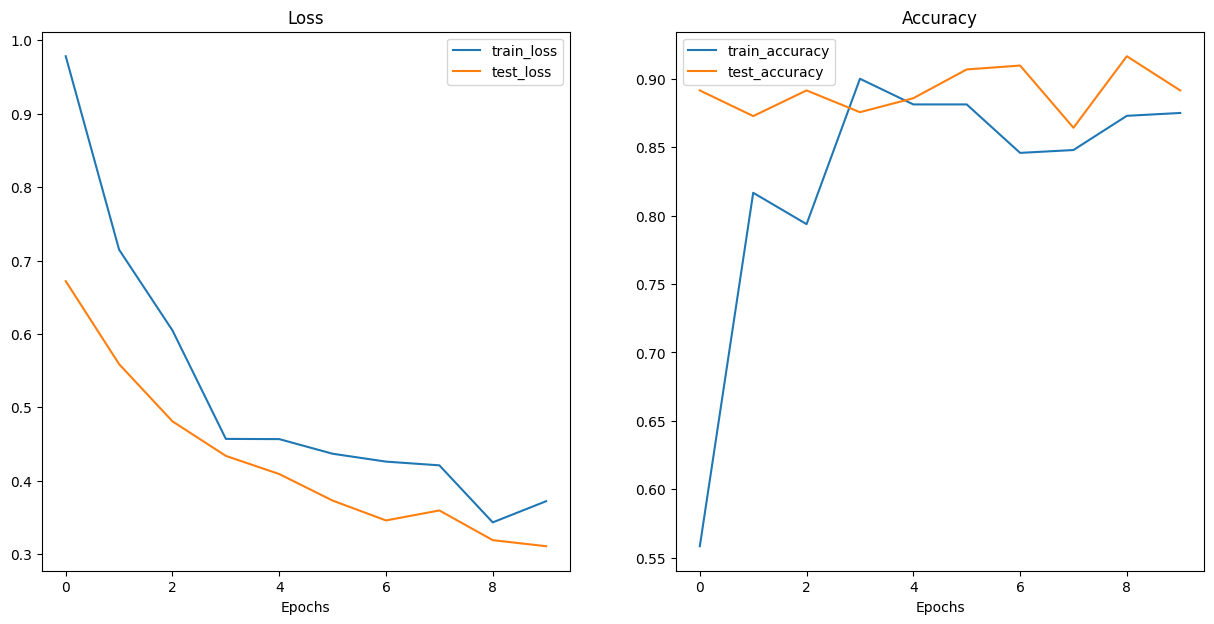

In [ ]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
  from helper_functions import plot_loss_curves
except:
  print("[INFO] Couldn't find helper_functions.py, downloading...")
  with open("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [ ]:
from typing import List, Tuple
from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
  # 2. Open image
  img = Image.open(image_path)

  # 3. Create transformation for image (if one doesn't exist)
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

  ### Predict on image ###

  # 4. Make sure the model is on the target device
  model.to(device)

  # 5. Turn on model evaluation mode and inference mode
  model.eval()
  with torch.inference_mode():
    # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
    transformed_image = image_transform(img).unsqueeze(dim=0)

    # 7. Make a prediction on image with an extra dimension and send it to the target device
    target_image_pred = model(transformed_image.to(device))

  # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # 9. Convert prediction probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # 10. Plot image with predicted label and probability
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False);

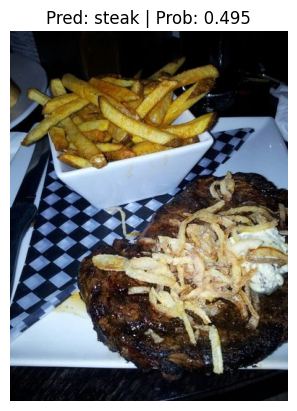

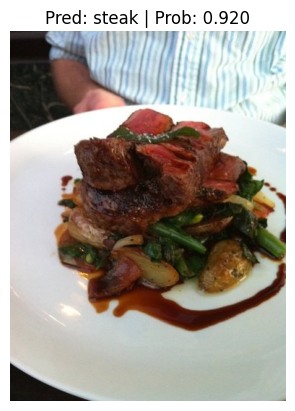

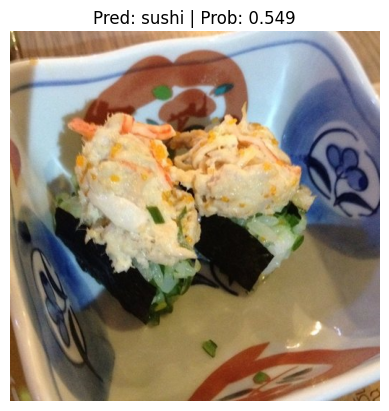

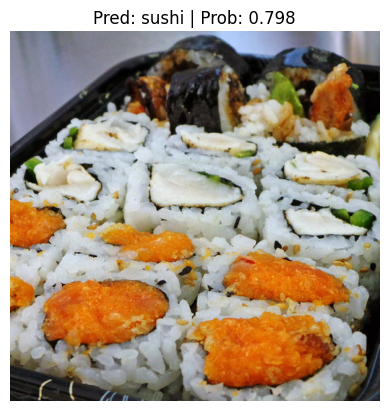

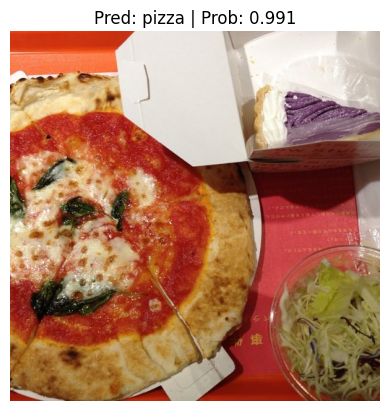

In [ ]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 5
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))              # get list of all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list,  # go through all of the test image paths
                                       k=num_images_to_plot)             # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      # transform=weights.transforms(),  # optionally pass in a specified transform from our pretrained model weights
                      image_size=(224, 224))

### Predict on your own image of pizza/steak/sushi

In [ ]:
"""
Ex 3. Predict on your own image of pizza/steak/sushi
"""
# Get custom images
!python going_modular/get_custom_data.py

DownLoading data/cheese-pizza.jpeg...
DownLoading data/pizza-slice.jpeg...
DownLoading data/pizza-slice2.jpeg...
DownLoading data/pizza-sliced.jpeg...
DownLoading data/pizza-sliced2.jpeg...
DownLoading data/pizza-partial-view.jpeg...
DownLoading data/pizza-partial-view2.jpeg...
DownLoading data/pizza-side-view.jpeg...


In [ ]:
!ls data

cheese-pizza.jpeg	  pizza-side-view.jpeg	pizza-sliced.jpeg
pizza-partial-view2.jpeg  pizza-slice2.jpeg	pizza-slice.jpeg
pizza-partial-view.jpeg   pizza-sliced2.jpeg	pizza_steak_sushi


In [ ]:
data_path = Path("data")

filenames = [
    "cheese-pizza.jpeg",
    "pizza-slice.jpeg",
    "pizza-slice2.jpeg",
    "pizza-sliced.jpeg",
    "pizza-sliced2.jpeg",
    "pizza-partial-view.jpeg",
    "pizza-partial-view2.jpeg",
    "pizza-side-view.jpeg"
]

for f in filenames:
  # Set custom image path
  custom_image_path = data_path / f
  # Predict on custom image
  pred_and_plot_image(model=model,
                      image_path=custom_image_path,
                      class_names=class_names,
                      image_size=(224, 224))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
"""
The length of a DataLoader in Python is determined by the number of batches it will produce from the dataset.
This number is calculated by dividing the total number of samples in the dataset by the batch size and potentially
applying a rounding operation depending on the drop_last argument.
"""
len(test_dataloader)  # 150 / 32 = 5

5

### Make predictions on the entire test dataset and plot a confusion matrix

In [ ]:
"""
Ex 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels.
"""
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)

    # Do the forward pass
    y_logit = model(X)

    # Turn predictions from logits to probabilities to labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)  # note: perform softmax on the "logits" dimension, not "batch" dimension
                                                          # (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())

  # Concatenate list of predictions into a tensor
  y_pred_tensor = torch.cat(y_preds)

print(y_pred_tensor)
y_pred_tensor.shape, len(test_dataloader.dataset)

Making predictions:   0%|          | 0/5 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1,
        1, 1, 2, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2,
        0, 2, 2, 2, 2, 2])


(torch.Size([150]), 150)

In [ ]:
# See if torchmetrics exists, if not, install it
try:
  import torchmetrics, mlxtend
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 813.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 48.6 MB/s eta 0:00:00
mlxtend version: 0.23.4


MulticlassConfusionMatrix()
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

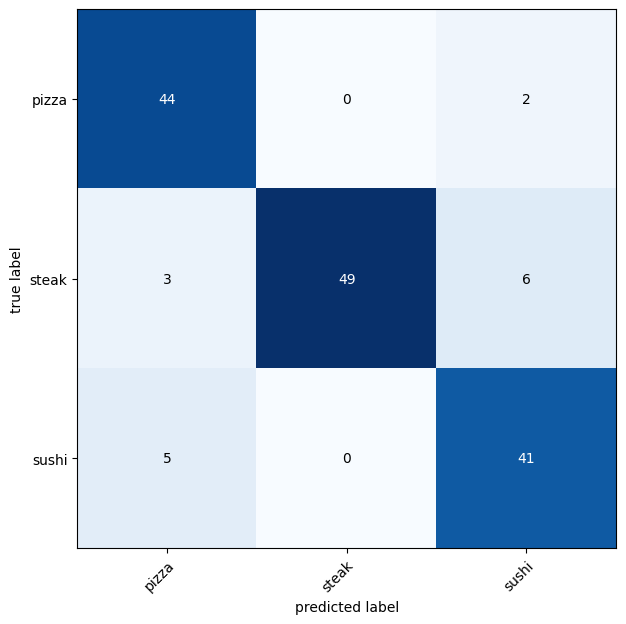

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
print(confmat)

# Get truth labels for test dataset
test_truth = torch.cat([y for X, y in test_dataloader])
print(test_truth)

# Convert the target list to a tensor
target_tensor = torch.tensor(test_dataloader.dataset.targets)

confmat_tensor = confmat(preds=y_pred_tensor,
                         target=target_tensor)  # Use the converted tensor
print(target_tensor)
s = "is" if torch.equal(test_truth, target_tensor) else "is NOT"
print(f"test_truth {s} equal to target_tensor")
#print(torch.eq(test_truth, target_tensor))  # this compares each element in the two tensors
print(target_tensor.shape)
print(confmat_tensor)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
);

### Plot the "most wrong" of the predictions

In [ ]:
"""
Ex 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images.
"""
# Create a function to return a list of dictionaries with sample, label, prediction, pred prob
def predict_and_store(model, test_paths, transform, class_names, device):
  pred_list = []
  test_preds = []
  for path in test_paths:
    # Create empty dict to store info for each sample
    pred_dict = {}

    # Save sample path
    pred_dict["image_path"] = path

    # Save class name
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # Save prediction and pred prob
    from PIL import Image
    img = Image.open(path)
    transformed_image = transform(img).unsqueeze(dim=0)  # transform image and add batch dimension
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]  # or could replace .cpu() with .item() since pred_label is a scalar value (index to the class_name)

      # Make sure the highest pred_prob is back on the CPU for the dictionary
      pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
      pred_dict["pred_class"] = pred_class  # predicted class name

      test_preds.append(pred_label.cpu())

    # Does the prediction match the true label?
    pred_dict["correct"] = class_name == pred_class
    # print(pred_dict)

    # Add sample dict to list of preds
    pred_list.append(pred_dict)

    test_preds_tensor = torch.cat(test_preds)

  return pred_list, test_preds_tensor

In [ ]:
# Get list of all image paths from test data
from pathlib import Path

""" Note: Path.glob() and os.listdir() don't return file paths in the same order as DataLoader datasets
"""
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
# test_labels = [path.parent.stem for path in test_image_path_list]

simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

pred_list, test_preds_tensor = predict_and_store(
    model=model,
    test_paths=test_image_path_list,
    transform=auto_transforms,  # auto_transforms were used last for the model's test_dataloader (manual_transforms gives 9 False, simple_transform isn't right (many False))
    class_names=class_names,
    device=device
)
pred_list[:5], test_preds_tensor

([{'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/1315645.jpg'),
   'class_name': 'pizza',
   'pred_prob': 0.8405867218971252,
   'pred_class': 'pizza',
   'correct': True},
  {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/796922.jpg'),
   'class_name': 'pizza',
   'pred_prob': 0.3980584144592285,
   'pred_class': 'sushi',
   'correct': False},
  {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
   'class_name': 'pizza',
   'pred_prob': 0.9700212478637695,
   'pred_class': 'pizza',
   'correct': True},
  {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/2901001.jpg'),
   'class_name': 'pizza',
   'pred_prob': 0.9110808968544006,
   'pred_class': 'pizza',
   'correct': True},
  {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/998005.jpg'),
   'class_name': 'pizza',
   'pred_prob': 0.6979393362998962,
   'pred_class': 'pizza',
   'correct': True}],
 tensor([0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
"""
Build a truths tensor from the class order in test_image_path_list since it isn't
the same order as the dataset in the test_dataloader. Without a true labels tensor
the confusion matrix won't be correct.
"""
class_indices_list = []
for item in pred_list:
  if item["class_name"] == "pizza":
    index = 0;
  elif item["class_name"] == "steak":
    index = 1;
  elif item["class_name"] == "sushi":
    index = 2;
  class_indices_list.append(index)

true_labels_tensor = torch.tensor(class_indices_list)
true_labels_tensor

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

test_preds_tensor is NOT equal to y_pred_tensor
tensor([0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1,
        1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
        2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1,
        1, 1, 2, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

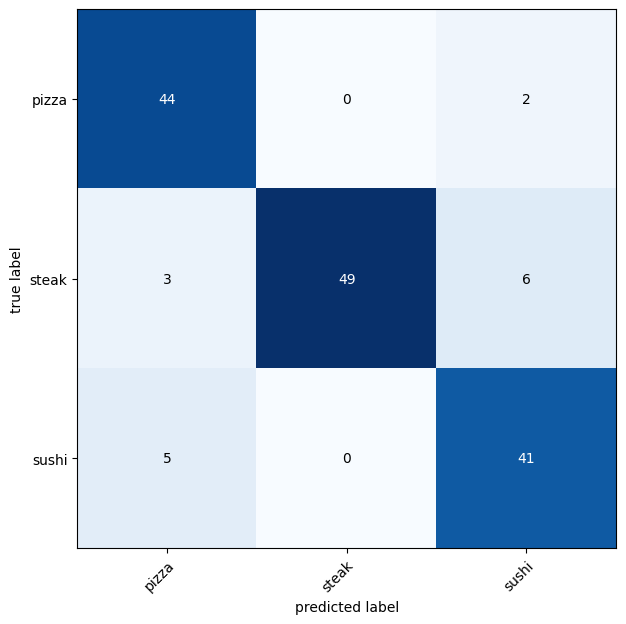

In [ ]:
confmat_tensor = confmat(preds=test_preds_tensor,
                         target=true_labels_tensor)  # Use the correct tensor

s = "is" if torch.equal(test_preds_tensor, y_pred_tensor) else "is NOT"
print(f"test_preds_tensor {s} equal to y_pred_tensor")
print(test_preds_tensor)
print(y_pred_tensor)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
);

In [ ]:
# Turn pred_list (test pred dicts) into a DataFrame
import pandas as pd
test_pred_df = pd.DataFrame(pred_list)

# Sort DataFrame by 'correct' then by 'pred_prob'
test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False], inplace=True)  # Add inplace=True to modify the DataFrame directly
#test_pred_df.head()
test_pred_df[:20]

image_path class_name  pred_prob  \
91     data/pizza_steak_sushi/test/steak/39461.jpg      steak   0.716914   
102  data/pizza_steak_sushi/test/steak/1655387.jpg      steak   0.641558   
62   data/pizza_steak_sushi/test/steak/1285886.jpg      steak   0.640431   
27     data/pizza_steak_sushi/test/pizza/44810.jpg      pizza   0.614086   
115  data/pizza_steak_sushi/test/sushi/3834718.jpg      sushi   0.600614   
121   data/pizza_steak_sushi/test/sushi/124279.jpg      sushi   0.594895   
81   data/pizza_steak_sushi/test/steak/3479599.jpg      steak   0.574954   
85   data/pizza_steak_sushi/test/steak/1335842.jpg      steak   0.519908   
127   data/pizza_steak_sushi/test/sushi/167716.jpg      sushi   0.507603   
76   data/pizza_steak_sushi/test/steak/3757027.jpg      steak   0.494887   
80   data/pizza_steak_sushi/test/steak/3553838.jpg      steak   0.491011   
126   data/pizza_steak_sushi/test/sushi/472912.jpg      sushi   0.488243   
69    data/pizza_steak_sushi/test/steak/399377.jpg      steak   0.464602   
49   data/pizza_steak_sushi/test/steak/2353677.jpg      steak   0.443086   
1     data/pizza_steak_sushi/test/pizza/796922.jpg      pizza   0.398058   
136   data/pizza_steak_sushi/test/sushi/705150.jpg      sushi   0.384802   
130   data/pizza_steak_sushi/test/sushi/911808.jpg      sushi   0.993501   
32    data/pizza_steak_sushi/test/pizza/482858.jpg      pizza   0.991786   
78    data/pizza_steak_sushi/test/steak/476333.jpg      steak   0.990444   
99    data/pizza_steak_sushi/test/steak/289822.jpg      steak   0.988854   

    pred_class  correct  
91       pizza    False  
102      sushi    False  
62       sushi    False  
27       sushi    False  
115      pizza    False  
121      pizza    False  
81       sushi    False  
85       pizza    False  
127      pizza    False  
76       sushi    False  
80       sushi    False  
126      pizza    False  
69       sushi    False  
49       pizza    False  
1        sushi    False  
136      pizza    False  
130      sushi     True  
32       pizza     True  
78       steak     True  
99       steak     True

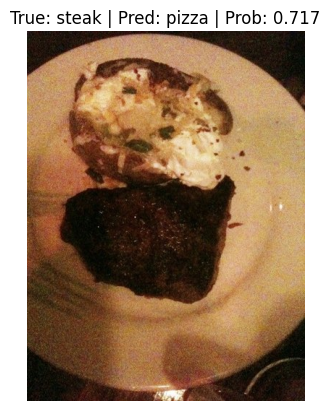

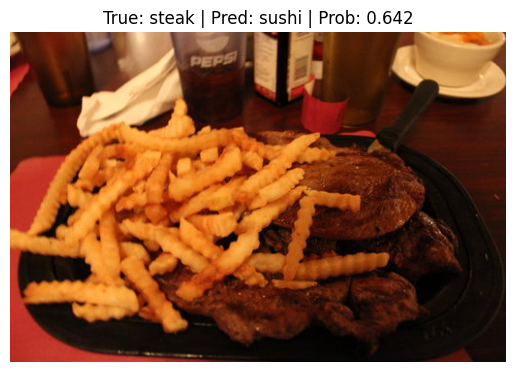

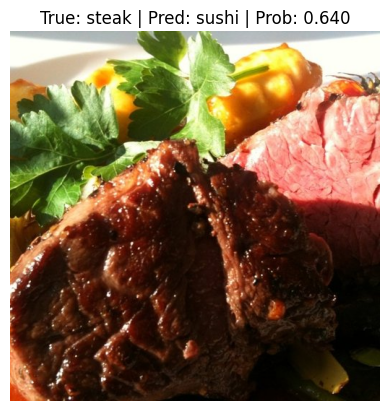

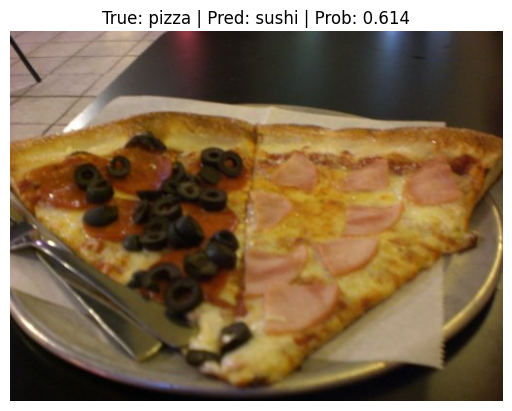

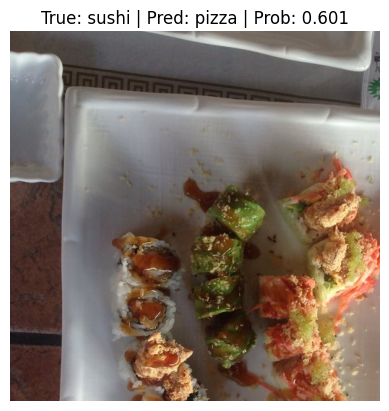

In [ ]:
# Plot the top 5 most wrong images
import torchvision
import matplotlib.pyplot as plt

top_5_most_wrong = test_pred_df[:5]

for row in top_5_most_wrong.iterrows():
  row = row[1]
  image_path = row["image_path"]
  true_label = row["class_name"]
  pred_class = row["pred_class"]
  pred_prob = row["pred_prob"]

  img = torchvision.io.read_image(str(image_path)).permute(1, 2, 0)  # get image as tensor and permute to [height, width, color_channels]
  plt.imshow(img)
  plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
  plt.axis(False)
  plt.show()

In [ ]:
# Sorting without pandas
sorted_pred_list = sorted(pred_list, key=lambda x: (x['correct']==False, x['pred_prob']), reverse=True,)
sorted_pred_list[:20]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/steak/39461.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.7169142961502075,
  'pred_class': 'pizza',
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/1655387.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.641557514667511,
  'pred_class': 'sushi',
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/1285886.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.6404314637184143,
  'pred_class': 'sushi',
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/44810.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.6140855550765991,
  'pred_class': 'sushi',
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/3834718.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.6006141304969788,
  'pred_class': 'pizza',
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/124279.jpg'),
  'class_name': 'sus

## Try a different model from torchvision.models

In [ ]:
"""
Ex 6. Try a different model from torchvision.models on the Pizza, Steak, Sushi data
"""
weights_B2 = torchvision.models.EfficientNet_B2_Weights.DEFAULT  # .DEFAULT = best available weights from pretraining on ImageNet
weights_B2

EfficientNet_B2_Weights.IMAGENET1K_V1

In [ ]:
auto_transforms_B2 = weights_B2.transforms()
auto_transforms_B2

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# Create training and testing DataLoaders and get a list of class names
train_dataloader_B2, test_dataloader_B2, class_names_B2 = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transforms_B2,  # perform the same data transforms on our training data as the pretrained model
    batch_size=32
)
train_dataloader_B2, test_dataloader_B2, class_names_B2

(<torch.utils.data.dataloader.DataLoader at 0x7859b04d6390>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# NEW: Set up the model with pretrained weights and send it to the target device (torchvision v0.13+)
model_B2 = torchvision.models.efficientnet_b2(weights=weights_B2).to(device)

# View it to see dropout rate and number of in_features
#model_B2
"""
  (classifier): Sequential(
    (0): Dropout(p=0.3, inplace=True)
    (1): Linear(in_features=1408, out_features=1000, bias=True)
  )
"""

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 78.6MB/s]


'\n  (classifier): Sequential(\n    (0): Dropout(p=0.3, inplace=True)\n    (1): Linear(in_features=1408, out_features=1000, bias=True)\n  )\n'

In [ ]:
# Print a summary using torchinfo
summary(model=model_B2,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [ ]:
# Freeze all base layers in the "features" section of the model
for parm in model_B2.features.parameters():
  parm.requires_grad = False

In [ ]:
""" Adjust the output layer or the classifier portion of our pretrained model to our needs (out_features=3). """
# Set manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names_B2)

# Recreate the classifier layer and seed it to the target device
"""
As bigger models need more regularization, Dropout ratio is linearly increased from 0.2 for EfficientNet_B0 to 0.5 for EfficientNet_B7.
"""
model_B2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.3, inplace=True),      # find this by displaying model_B2
    torch.nn.Linear(in_features=1408,           # also found in the model_B2 view
                    out_features=output_shape,  # same number of output units as number of classes
                    bias=True)).to(device)

# View the summary after freezing the features and changing the output classifier layer
summary(model=model_B2,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### Train the (EffNetB2) model

In [ ]:
""" Train the model """
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

optimizer_b2 = torch.optim.Adam(model_B2.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

""" Note: We're only going to be training the parameters classifier here as all of the other parameters in our model have been frozen. """
# Set up training and save the results
results_B2 = engine.train(model=model_B2,
                          train_dataloader=train_dataloader_B2,
                          test_dataloader=test_dataloader_B2,
                          optimizer=optimizer_b2,
                          loss_fn=loss_fn,
                          epochs=10,
                          device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total running time: {end_time - start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625
[INFO] Total running time: 56.526 seconds


In [ ]:
class_names_B2

['pizza', 'steak', 'sushi']

### Make predictions and plot a confusion matrix

In [ ]:
# Make predictions and store in a list of dictionaries
pred_list_B2, test_preds_tensor_B2 = predict_and_store(
    model=model_B2,
    test_paths=test_image_path_list,
    transform=auto_transforms_B2,
    class_names=class_names_B2,
    device=device
)
pred_list_B2[:5], test_preds_tensor_B2

([{'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/1315645.jpg'),
   'class_name': 'pizza',
   'pred_prob': 0.7744606733322144,
   'pred_class': 'pizza',
   'correct': True},
  {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/796922.jpg'),
   'class_name': 'pizza',
   'pred_prob': 0.7070100903511047,
   'pred_class': 'pizza',
   'correct': True},
  {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
   'class_name': 'pizza',
   'pred_prob': 0.9468300938606262,
   'pred_class': 'pizza',
   'correct': True},
  {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/2901001.jpg'),
   'class_name': 'pizza',
   'pred_prob': 0.7433852553367615,
   'pred_class': 'pizza',
   'correct': True},
  {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/998005.jpg'),
   'class_name': 'pizza',
   'pred_prob': 0.5598537921905518,
   'pred_class': 'pizza',
   'correct': True}],
 tensor([0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [ ]:
"""
Build a truths tensor from the class order in test_image_path_list since it isn't
the same order as the dataset in the test_dataloader. Without a true labels tensor
the confusion matrix won't be correct.
"""
class_indices_list = []
for item in pred_list_B2:
  if item["class_name"] == "pizza":
    index = 0;
  elif item["class_name"] == "steak":
    index = 1;
  elif item["class_name"] == "sushi":
    index = 2;
  class_indices_list.append(index)

true_labels_tensor = torch.tensor(class_indices_list)
true_labels_tensor

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

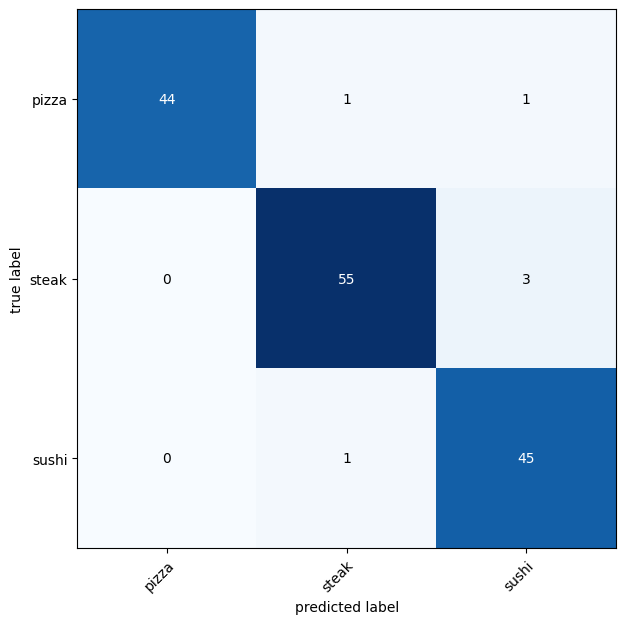

In [ ]:
# Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names_B2), task='multiclass')

# Get truth labels for test dataset
""" We can't use these since the test_image_path_list order isn't the same as the dataset's sample order """
test_truth_B2 = torch.cat([y for X, y in test_dataloader_B2])

confmat_tensor_B2 = confmat(preds=test_preds_tensor_B2,
                            target=true_labels_tensor)  # Use the correct tensor (built earlier from the same test_image_path_list)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor_B2.numpy(),
    class_names=class_names_B2,
    figsize=(10, 7)
);

### Plot the 5 "most wrong" predictions

In [ ]:
# Sort the list of dictionaries, False elements first, pred_prob high to low
sorted_pred_list_B2 = sorted(pred_list_B2, key=lambda x: (x['correct']==False, x['pred_prob']), reverse=True)

# Turn sorted list into a DataFrame of top 5 wrong
test_pred_df_B2_top5 = pd.DataFrame(sorted_pred_list_B2[:5])
test_pred_df_B2 = pd.DataFrame(sorted_pred_list_B2[:10])
test_pred_df_B2

image_path class_name  pred_prob  \
0  data/pizza_steak_sushi/test/sushi/1404154.jpg      sushi   0.637496   
1  data/pizza_steak_sushi/test/steak/3757027.jpg      steak   0.591473   
2  data/pizza_steak_sushi/test/steak/1902895.jpg      steak   0.523888   
3  data/pizza_steak_sushi/test/pizza/1618659.jpg      pizza   0.509935   
4   data/pizza_steak_sushi/test/steak/100274.jpg      steak   0.391100   
5   data/pizza_steak_sushi/test/pizza/419962.jpg      pizza   0.373355   
6  data/pizza_steak_sushi/test/pizza/1001116.jpg      pizza   0.994124   
7  data/pizza_steak_sushi/test/pizza/1067986.jpg      pizza   0.991904   
8  data/pizza_steak_sushi/test/steak/1302563.jpg      steak   0.989794   
9  data/pizza_steak_sushi/test/pizza/3497151.jpg      pizza   0.987367   

  pred_class  correct  
0      steak    False  
1      sushi    False  
2      sushi    False  
3      sushi    False  
4      sushi    False  
5      steak    False  
6      pizza     True  
7      pizza     True  
8      steak     True  
9      pizza     True

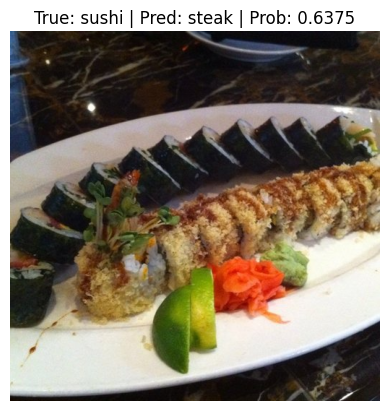

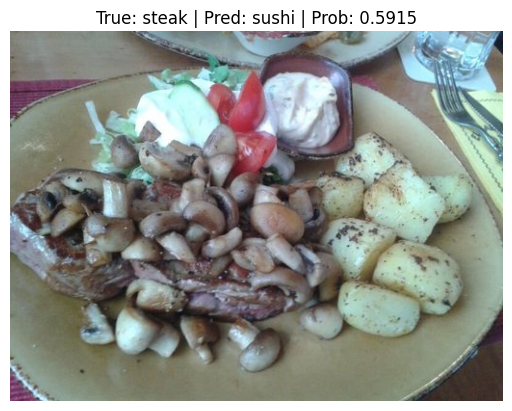

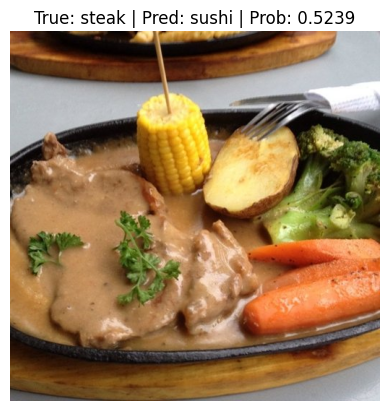

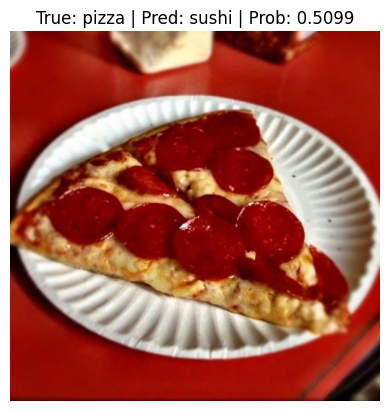

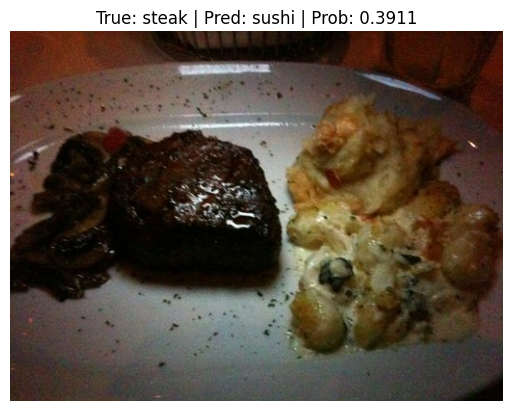

In [ ]:
# Plot the 5 most wrong images
for row in test_pred_df_B2_top5.iterrows():
  row = row[1]
  image_path = row["image_path"]
  true_label = row["class_name"]
  pred_class = row["pred_class"]
  pred_prob = row["pred_prob"]

  img = torchvision.io.read_image(str(image_path)).permute(1, 2, 0)  # get image as tensor and permute to [height, width, color_channels]
  plt.imshow(img)
  plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.4f}")
  plt.axis(False)
  plt.show()

In [ ]:
# Check results with 20% of data for 10 epochs using eff_b0
max(results["test_acc"]), min(results["test_loss"])

(0.9164772727272726, 0.3106922715902328)

In [ ]:
# Check results_B2 with 20% of data for 10 epochs using eff_b2 (double the model parameters)
max(results_B2["test_acc"]), min(results_B2["test_loss"])

(0.96875, 0.2810868382453918)